# We only calculate the E and B mode maps on a small portion of the sky. 
We do this by constructing a mask near the equator and evaluating the E and B modes only on pixels not masked.
We do use the all the Stokes Q and U maps however. So we dont have to worry about masking while evaluating these 
E and B mode maps.

In [1]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
from modules_v0 import local_eb_kernel_masked as rk
from modules_v0 import mod_rad_cl_correction as mrcl
from scipy.integrate import quad
import os
import time

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
respath="../../figures/simulated/high_res_qu2eb/lensingb/"
!mkdir $respath

figpath=respath
datapath=respath + "generated_data/"
!mkdir $datapath
genplots=True
nomask=True

mkdir: ../../figures/simulated/high_res_qu2eb/lensingb/: File exists
mkdir: ../../figures/simulated/high_res_qu2eb/lensingb/generated_data/: File exists


In [3]:
from matplotlib import rcParams,rc
params = {'savefig.dpi': 200,
          'axes.labelsize': 15,
          'text.fontsize': 15,
          'axes.linewidth' : 2,
          'lines.linewidth' : 2,
          'font.size': 15,
          'xtick.labelsize': 15,
          'ytick.major.pad': 6,
          'xtick.major.pad': 6,
          'ytick.labelsize': 15,
          'text.usetex': True,
          'font.family':'sans-serif',
          'font.sans-serif':'FreeSans',
          'image.cmap':'jet'}
rc('text.latex', preamble='\usepackage{sfmath}')
rcParams.update(params)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
nside=256 ; upnside=256 ; npix=h.nside2npix(upnside) ; psize=sqrt(4.*pi/npix)*180./pi
lmax=int(3*nside) ; print lmax ; lmin=2
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

odisc=min(180.,180.*(24./lmax))
#odisc=8
#odisc=30*psize
print odisc ; print psize

768
5.625
0.229032427454


In [5]:
#filenames=[]
#filenames=append(filenames,datapath + "rteb_2beta_nside512.fits")
#filenames=append(filenames,datapath + "rteb_1beta_nside512.fits")
#filenames=append(filenames,datapath + "mask.fits")
#filenames=append(filenames,datapath + "fsteb.fits")

#fexist=True
#for f in filenames:
#    fexist=fexist and os.path.isfile(f)
#fexist

In [6]:
def get_alm(cl,lmax,seed=0):
    random.seed(seed)
    almsize=h.Alm.getsize(lmax,lmax)
    ar=random.normal(size=almsize)
    ai=random.normal(size=almsize)
    alm=zeros(almsize,complex)
    for i in range(almsize):
        l,m=h.Alm.getlm(lmax,i)
        if m==0:
            alm[i]=complex(ar[i],0.)*sqrt(cl[l])
        else:
            alm[i]=complex(ar[i],ai[i])*sqrt(0.5*cl[l])
    return alm

In [7]:
cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
cllens=[cltemp[0],cltemp[1],cltemp[2],cltemp[3]*0] # Reverse E and B spectra

cltemp=h.read_cl("../../data/cl_rem3.fits")
clr0=[cltemp[0],cltemp[1],cltemp[2]*0.,cltemp[3]*0] # Reverse E and B spectra
clrp1=[cltemp[0],cltemp[1],cltemp[2]*10.,cltemp[3]*0] # Reverse E and B spectra

#cl=[cltemp[0],cltemp[2],cltemp[1],cltemp[3]*0] # Reverse E and B spectra

random.seed(0) ; tqur0=h.synfast(clr0,nside,lmax=lmax,mmax=lmax,pol=True,new=True,verbose=False)
random.seed(0) ; tqurp1=h.synfast(clrp1,nside,lmax=lmax,mmax=lmax,pol=True,new=True,verbose=False)

# Get teb maps from Healpix.
alm=h.map2alm(tqur0,lmax=lmax,pol=True,iter=5) ; tebr0=h.alm2map(alm,nside,pol=False,verbose=False)
cldr0=h.alm2cl(alm)

alm=h.map2alm(tqurp1,lmax=lmax,pol=True,iter=5) ; tebrp1=h.alm2map(alm,nside,pol=False,verbose=False)
cldrp1=h.alm2cl(alm)

# Get Q/U corresponding to E and B modes.
#alm[2][:]=0.0 ; equ=h.alm2map(alm,nside=nside,pol=True,verbose=False)
#alm=h.map2alm(tqu,lmax=3*nside,pol=True) ; alm[1][:]=0.0 ; bqu=h.alm2map(alm,nside=nside,pol=True,verbose=False)

fl=ones(3*nside+1,float) ; fl[:lmin+1]=0

In [8]:
alm=[get_alm(clr0[0],lmax,1),get_alm(clr0[1],lmax,2),get_alm(clr0[2],lmax,3)]
tebr0=h.alm2map(alm,nside,pol=False,verbose=False)
tqur0=h.alm2map(alm,nside,pol=True,verbose=False)

alm=[get_alm(clrp1[0],lmax,1),get_alm(clrp1[1],lmax,2),get_alm(clrp1[2],lmax,3)]
tebrp1=h.alm2map(alm,nside,pol=False,verbose=False)
tqurp1=h.alm2map(alm,nside,pol=True,verbose=False)
tebrp1p=h.alm2map(h.map2alm(tqurp1,lmax=lmax),nside,pol=False,verbose=False)

<IPython.core.display.Javascript object>


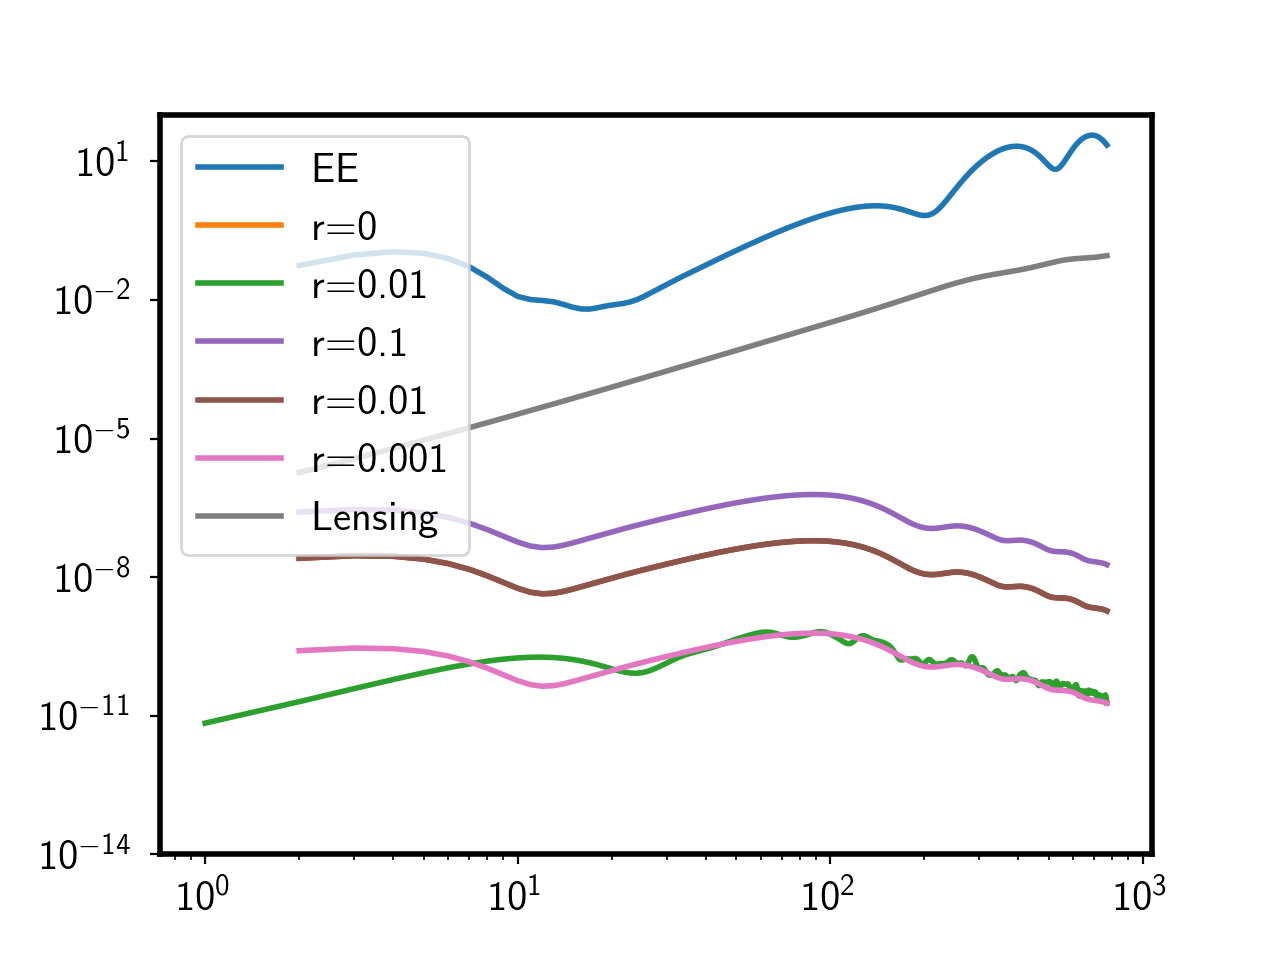

(1e-14, 100.0)

In [31]:
figure()
plot(ell,ell*(ell+1)*cllens[1][:lmax+1]/(2.*pi),label="EE")
plot(ell,ell*(ell+1)*cldr0[2][:lmax+1]/(2.*pi),label="r=0")
plot(ell,ell*(ell+1)*cldrp1[2][:lmax+1]/(2.*pi),label="r=0.01")
plot(ell,ell*(ell+1)*clrp1[2][:lmax+1]/(2.*pi),label="")
plot(ell,ell*(ell+1)*clrp1[2][:lmax+1]*10./(2.*pi),label="r=0.1")
plot(ell,ell*(ell+1)*clrp1[2][:lmax+1]*1./(2.*pi),label="r=0.01")
plot(ell,ell*(ell+1)*clrp1[2][:lmax+1]*0.01/(2.*pi),label="r=0.001")
plot(ell,ell*(ell+1)*cllens[2][:lmax+1]/(2.*pi),label="Lensing")
loglog()
legend(loc=0)
ylim(1e-14,1e2)

In [10]:
y=rk.real_space_queb_kernels(upnside,tmax=2.*odisc,maxlmax=3*upnside,sampling=4000)
y.calc_qu2eb_rad_kernel(700,lmin)
y.calc_qu2queb_rad_kernel(8,lmin)

odisc=min(180.,180.*(24./(700.)))

<IPython.core.display.Javascript object>


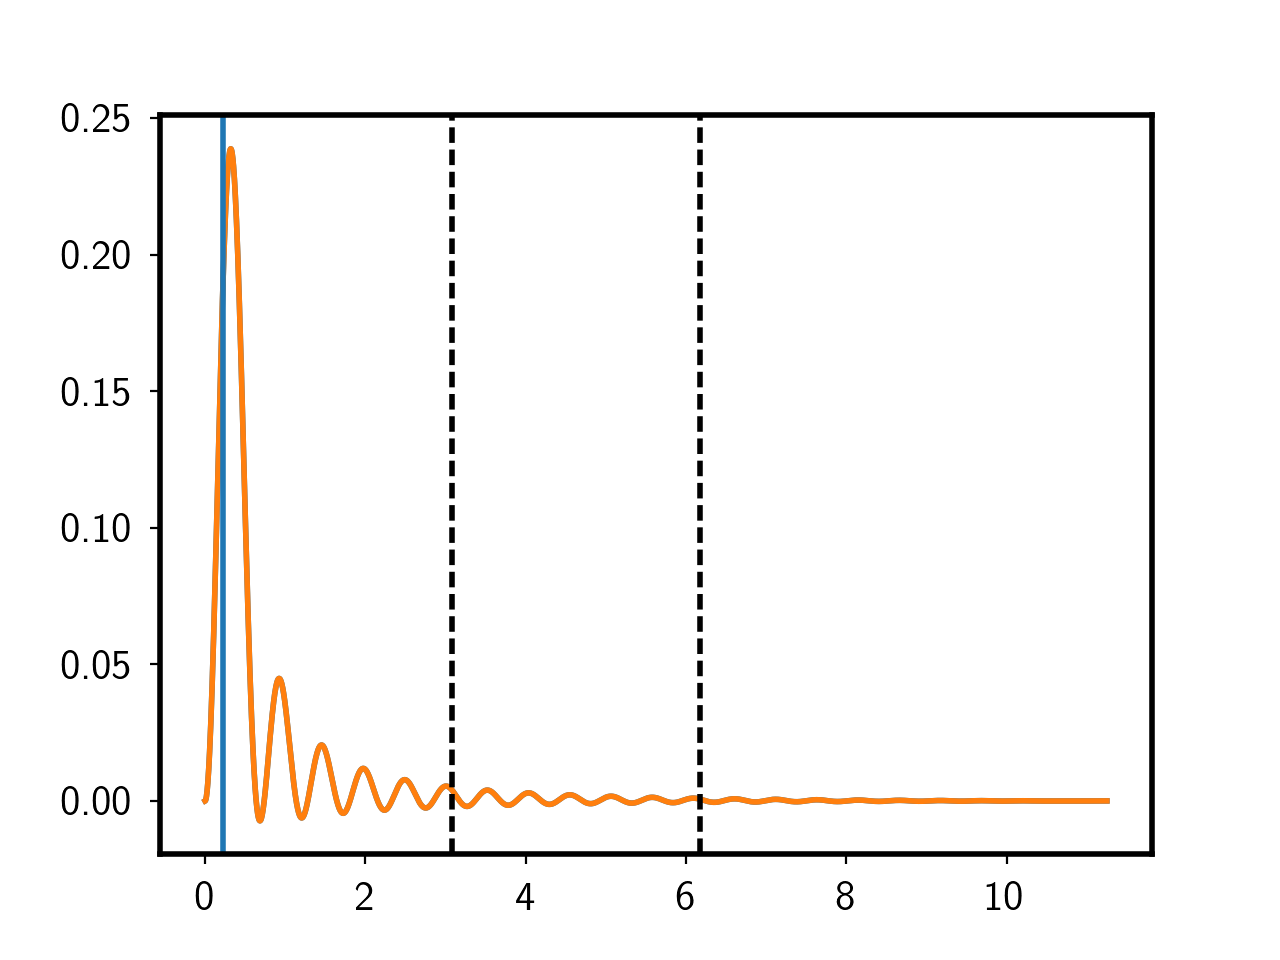

In [32]:
figure()
y.setup_taper(2*odisc,2*odisc) ; y.setup_fn_rad_ker()
plot(y.theta*180./pi,y.fn_rad_ker(y.theta))
y.setup_taper(2*odisc,2*odisc) ; y.setup_fn_rad_ker()
plot(y.theta*180./pi,y.fn_rad_ker(y.theta))
axvline(0.5*odisc,c="k",ls="dashed")
axvline(1.*odisc,c="k",ls="dashed")
axvline(sqrt(4.*pi/h.nside2npix(256))*180./pi)

<IPython.core.display.Javascript object>


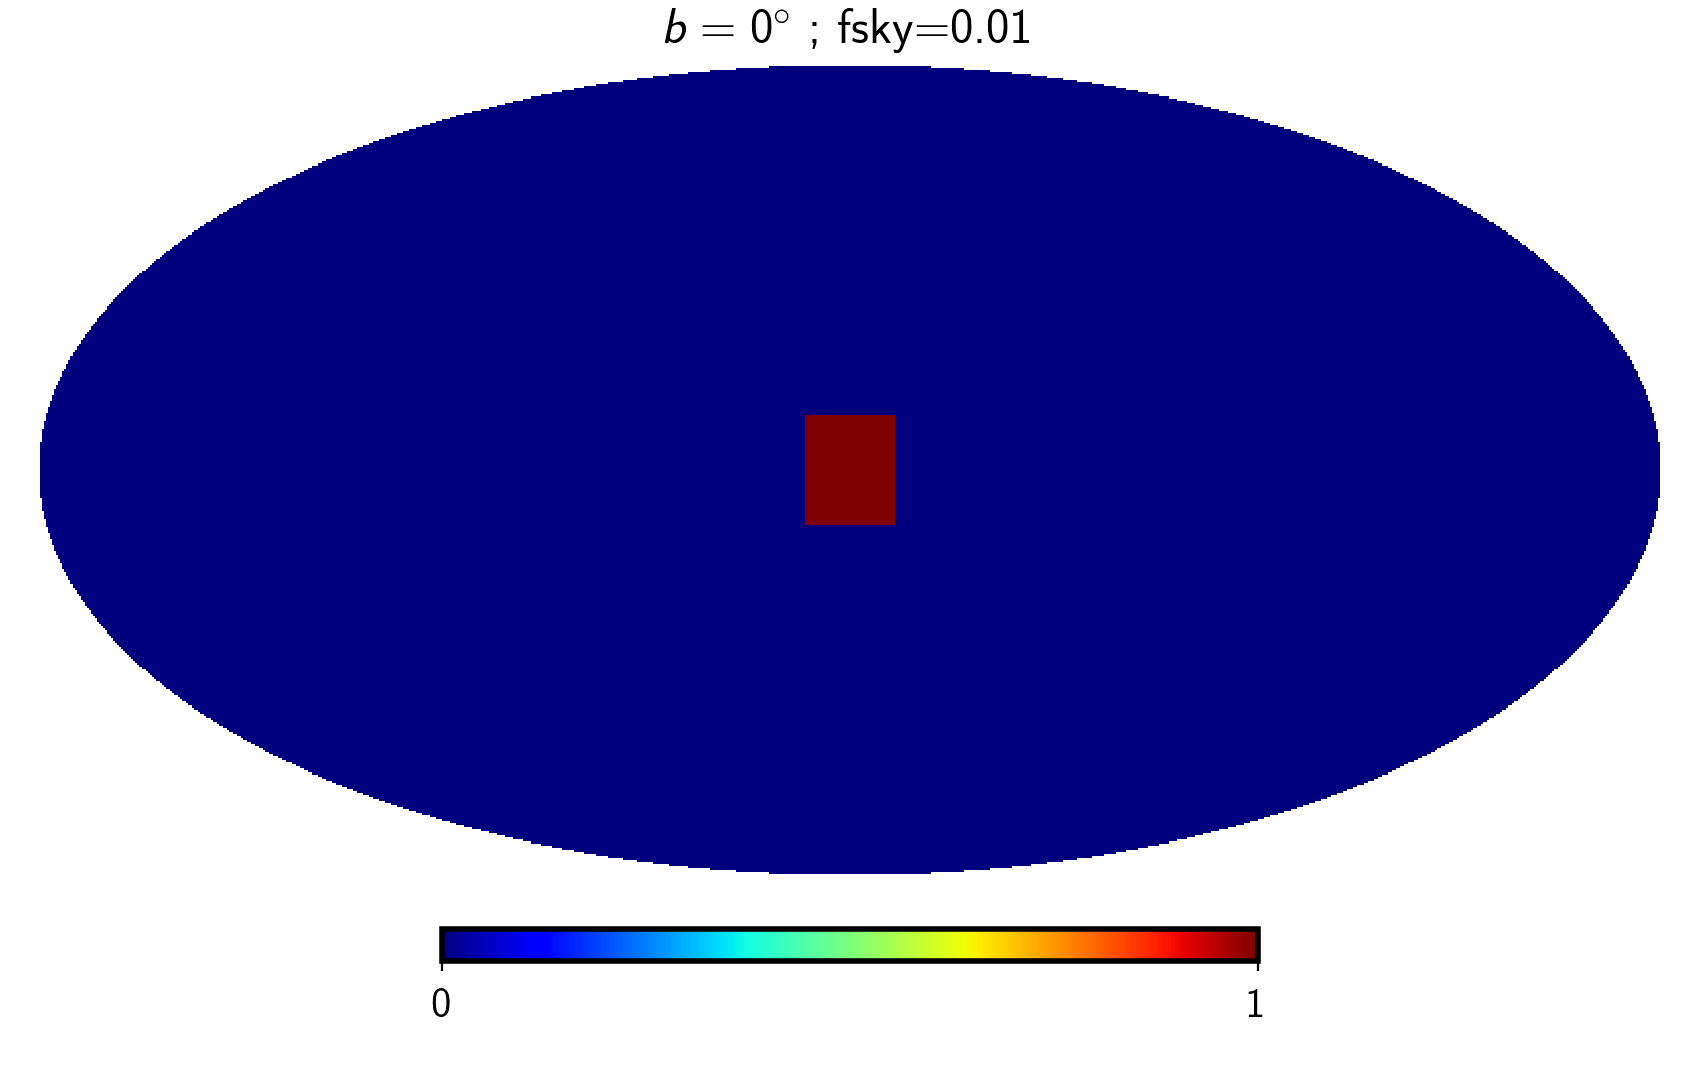

In [33]:
lat=90
tmask=zeros(npix,float)
pmask=zeros(npix,float)
pindex=arange(npix)
theta,phi=h.pix2ang(upnside,pindex)
theta=theta*180/pi ; phi=phi*180/pi
wband=10 ; phiband=10
tmask[theta<lat-wband]=1 ; tmask[theta>lat+wband]=1.
pmask[phi<phiband]=1. ; pmask[phi>360-phiband]=1.
mask=pmask*(1-tmask) ; fsky=sum(mask)/size(mask)
h.mollview(mask,title=r"$b=" + str(90-lat) + "^{\circ}$ ; fsky=" + str(round(fsky,3)))
if genplots:
    savefig(figpath + "mask-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

#h.write_map(datapath + "mask_nside" + str(nside) + "_lat" + str(90-lat) + ".fits",mask,overwrite=True)
#h.write_map(datapath + "fsteb_nside" + str(nside) + ".fits",teb,overwrite=True)

<IPython.core.display.Javascript object>


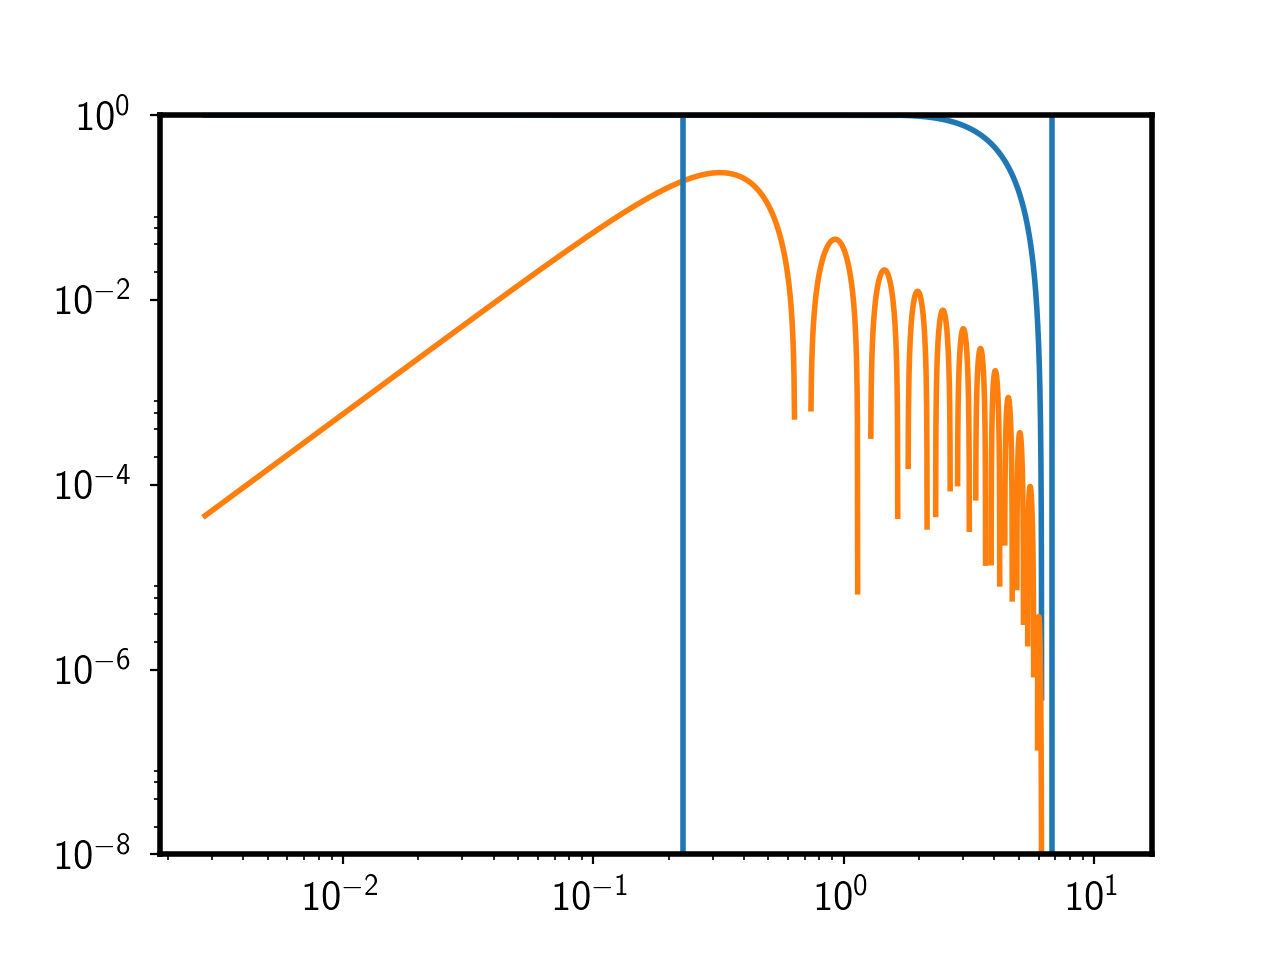

[]

In [34]:
y.setup_taper(1.*odisc,apow=0.75*odisc,sigma_cutoff=8.,tapertype=1)
y.setup_fn_rad_ker()

figure()
plot(y.theta*180./pi,y.fn_taper(y.theta))
plot(y.theta*180./pi,y.fn_rad_ker(y.theta))
axvline(1.1*odisc)
axvline(psize)
ylim(1e-8,1e0)
loglog()

In [35]:
y.setup_taper(1.*odisc,apow=0.75*odisc,sigma_cutoff=8.,tapertype=1)
y.setup_fn_rad_ker()

pindex=nonzero(mask)[0]
t1=time.time()
r0teb2=y.convert_qu2eb(tqur0,discsize=1.1*odisc,pindex=pindex)
print time.time()-t1

t1=time.time()
rp1teb2=y.convert_qu2eb(tqurp1,discsize=1.1*odisc,pindex=pindex)
print time.time()-t1

18.9245860577
18.5613949299


In [36]:
clr0teb2=h.alm2cl(h.map2alm(r0teb2*mask,lmax=lmax,pol=False))
clrp1teb2=h.alm2cl(h.map2alm(rp1teb2*mask,lmax=lmax,pol=False))
cldr0=h.alm2cl(h.map2alm(h.ud_grade(tebr0,upnside)*mask,lmax=lmax,pol=False))
cldrp1=h.alm2cl(h.map2alm(h.ud_grade(tebrp1,upnside)*mask,lmax=lmax,pol=False))

<IPython.core.display.Javascript object>


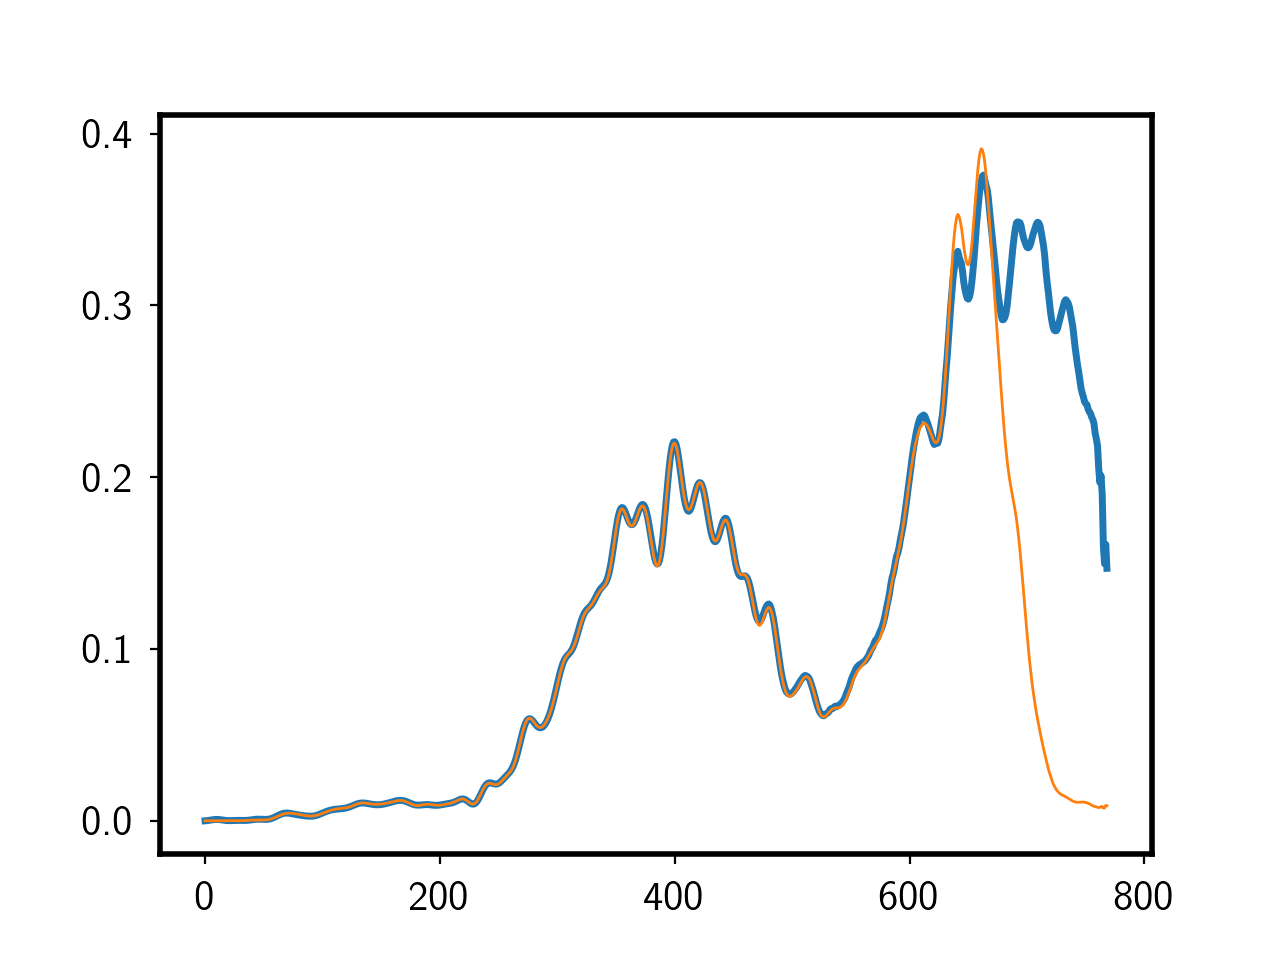

<IPython.core.display.Javascript object>


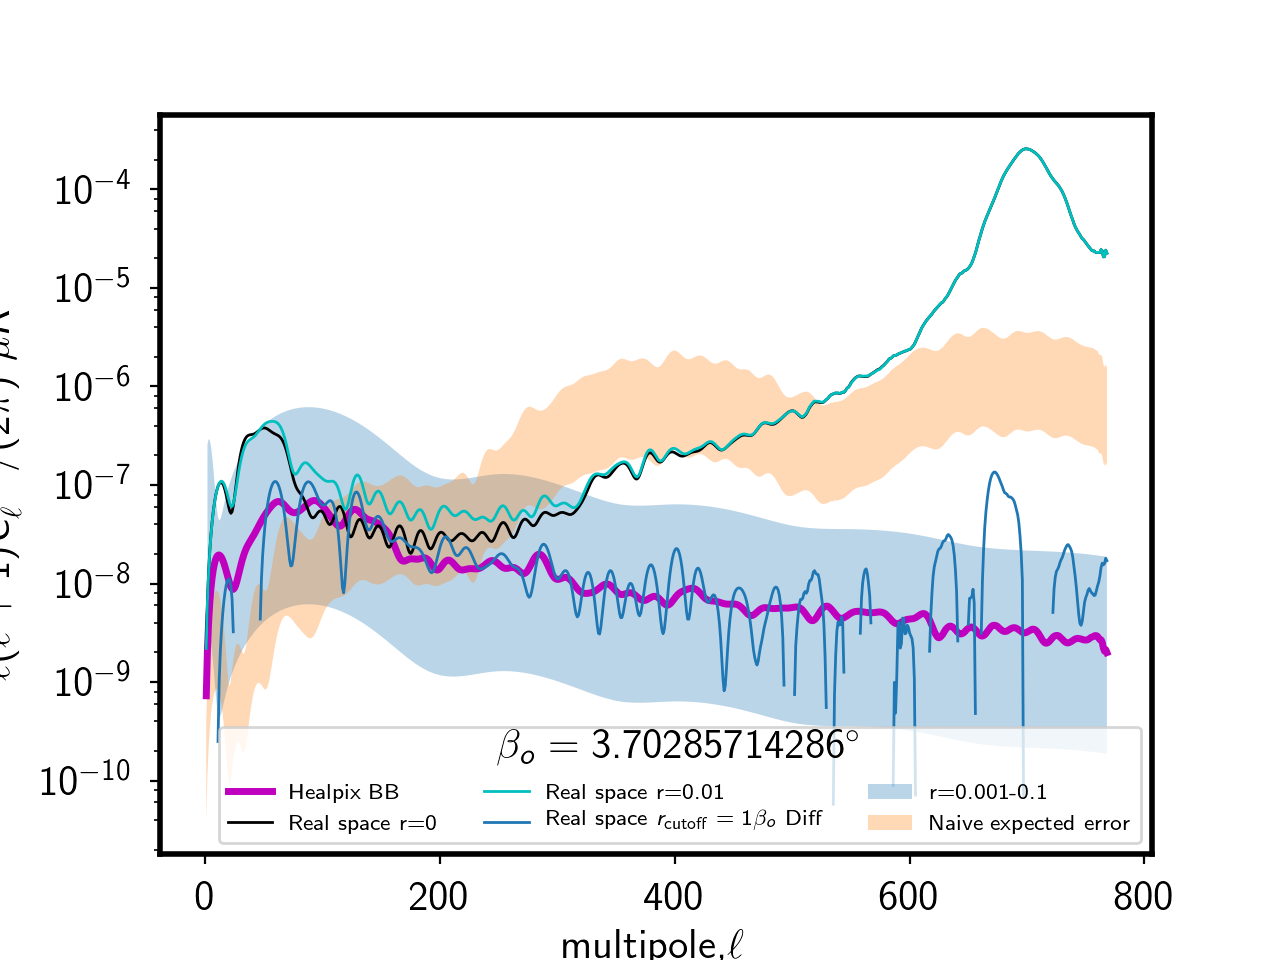

[]

In [37]:
clr=h.read_cl("../../data/cl_rem3.fits")

figure()
#plot(ell,fll*cllens[2][:lmax+1],lw=2.5,label="Lensing")
plot(ell,fll*cldr0[1],lw=2.5,label="Healpix EE")
plot(ell,fll*clr0teb2[1],"-",lw=1.,label=r"Real space $EE$")
#loglog() 

figure()
fill_between(ell,fll*clr[2][:lmax+1]*100,fll*clr[2][:lmax+1],label="r=0.001-0.1",alpha=0.3)
plot(ell,fll*cldrp1[2]/fsky,"m-",lw=2.5,label="Healpix BB")
fill_between(ell,fll*cldrp1[1]*1e-7/fsky,fll*cldrp1[1]*1e-8/fsky,alpha=0.3,lw=2.5,label="Naive expected error")
plot(ell,fll*clr0teb2[2]/fsky,"k-",lw=1.,label=r"Real space r=0")
plot(ell,fll*clrp1teb2[2]/fsky,"c-",lw=1.,label=r"Real space r=0.01")
plot(ell,fll*(clrp1teb2[2]-clr0teb2[2])/fsky,"-",lw=1.,label=r"Real space $r_{\rm cutoff}=1\beta_o$ Diff")

legend(loc=0,ncol=3,fontsize=8,title=r"$\beta_o=" + str(0.6*odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
semilogy()
#ylim(1e-10,1e-6)
#savefig(figpath + "bb-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

In [17]:
theta=90 ; phi=0
cpix=h.ang2pix(nside,theta*pi/180,phi*pi/180.)
alpha,beta,gamma,pix2=y.return_euler_angles_new(nside,cpix,discsize=1.1*odisc)

In [18]:
figure()
plot(beta*180./pi,cos(beta))

<IPython.core.display.Javascript object>

In [19]:
test1=zeros(npix,float)
test2=zeros(npix,float)
test3=zeros(npix,float)
test1[pix2]=cos(2.*alpha)#*y.fn_rad_ker(beta)
test2[pix2]=sin(2.*alpha)#*y.fn_rad_ker(beta)
test3[pix2]=(beta)*180./pi#*y.fn_rad_ker(beta)


h.gnomview(test1,rot=(phi,90-theta),xsize=400,reso=5)
h.gnomview(test2,rot=(phi,90-theta),xsize=400,reso=5)
h.gnomview(test3,rot=(phi,90-theta),xsize=400,reso=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
y.setup_taper(0.5*odisc,apow=0.25*odisc,sigma_cutoff=8.,tapertype=1)
y.setup_fn_rad_ker()

pindex=nonzero(mask)[0]

t1=time.time()
rteb_old=y.convert_qu2eb(tqurp1,discsize=.5*odisc,pindex=pindex)
print time.time()-t1

t1=time.time()
rtebr0_old=y.convert_qu2eb(tqur0,discsize=.5*odisc,pindex=pindex)
print time.time()-t1

t1=time.time()
rteb_new=y.convert_qu2eb_new(tqurp1,2*nside,discsize=.5*odisc,pindex=pindex)
print time.time()-t1

t1=time.time()
rtebr0_new=y.convert_qu2eb_new(tqur0,2*nside,discsize=.5*odisc,pindex=pindex)
print time.time()-t1

5.77719902992
6.18174600601
19.1282038689
13.7519481182


In [21]:
clrteb_old=h.alm2cl(h.map2alm(rteb_old*mask,lmax=lmax,pol=False))
clrtebr0_old=h.alm2cl(h.map2alm(rtebr0_old*mask,lmax=lmax,pol=False))
clrteb_new=h.alm2cl(h.map2alm(rteb_new*mask,lmax=lmax,pol=False))
clrtebr0_new=h.alm2cl(h.map2alm(rtebr0_new*mask,lmax=lmax,pol=False))
cldrp1=h.alm2cl(h.map2alm(h.ud_grade(tebrp1,upnside)*mask,lmax=lmax,pol=False))

In [22]:
clr=h.read_cl("../../data/cl_rem3.fits")


figure()
plot(ell,fll*clrteb_old[1]/fsky,"r-")
plot(ell,fll*clrteb_old[2]/fsky,"r-")
plot(ell,fll*clrteb_new[1]/16./fsky,"b--")
plot(ell,fll*clrteb_new[2]/16./fsky,"b--")
plot(ell,fll*clrtebr0_old[2]/fsky,"r-")
plot(ell,fll*clrtebr0_new[2]/16./fsky,"b--")
plot(ell,fll*cldrp1[2],"k--")
plot(ell,fll*cldrp1[1],"k--")
plot(ell,fll*cllens[2][:lmax+1],"--")
fill_between(ell,fll*clr[2][:lmax+1]*100,fll*clr[2][:lmax+1],label="r=0.001-0.1",alpha=0.3)

semilogy()

<IPython.core.display.Javascript object>

[]

In [23]:
figure()
plot(ell,ell*(cldrp1[2]-clrp1teb2[2])/clrp1teb2[2])
plot(ell,ell*(cldrp1[1]-clrp1teb2[1])/clrp1teb2[1])
ylim(-50,50)

<IPython.core.display.Javascript object>

(-50, 50)

In [24]:
clr=h.read_cl("../../data/cl_rem3.fits")

figure()
plot(ell,fll*cllens[2][:lmax+1],lw=2.5,label="Lensing")
#plot(ell,fll*cldr0[1],lw=2.5,label="Healpix EE")
#plot(ell,fll*clr0teb2[1],"-",lw=1.,label=r"Real space $EE$")

fill_between(ell,fll*clr[2][:lmax+1]*100,fll*clr[2][:lmax+1],label="r=0.001-0.1",alpha=0.3)
plot(ell,fll*cldrp1[2]/fsky,lw=2.5,label="Healpix BB")
plot(ell,fll*clr0teb2[2]/fsky,"k-",lw=1.,label=r"Real space r=0")
plot(ell,fll*clrp1teb2[2]/fsky,"-",lw=1.,label=r"Real space r=0.1")
plot(ell,fll*(clrp1teb2[2]-clr0teb2[2])/fsky,"-",lw=1.,label=r"Real space $r_{\rm cutoff}=1\beta_o$ Diff")

legend(loc=0,ncol=3,fontsize=8,title=r"$\beta_o=" + str(0.6*odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
semilogy()
#ylim(1e-10,1e-8)
#savefig(figpath + "bb-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>

[]

In [25]:
clr=h.read_cl("../../data/cl_rem3.fits")

figure()
#plot(ell,fll*cllens[2][:lmax+1]*fsky,lw=2.5,label="Lensing")
#plot(ell,fll*cldr0[1],lw=2.5,label="Healpix EE")
#plot(ell,fll*clr0teb2[1],"-",lw=1.,label=r"Real space $EE$")

plot(ell,fll*clr[2][:lmax+1]*100*fsky,"-",lw=4.,label="r=0.1",alpha=0.3)
plot(ell,fll*cldrp1[2],lw=2.5,label="Healpix BB")
plot(ell,fll*clr0teb2[2],"k-",lw=1.,label=r"Real space r=0")
plot(ell,fll*clrp1teb2[2],"-",lw=1.,label=r"Real space r=0.1")
plot(ell,fll*(clrp1teb2[2]-clr0teb2[2]),"-",lw=1.,label=r"Real space $r_{\rm cutoff}=1\beta_o$ Diff")

legend(loc=0,ncol=3,fontsize=8,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
semilogy()
ylim(1e-10,1e-8)
savefig(figpath + "bb-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>

In [26]:
clr=h.read_cl("../../data/cl_rem3.fits")

figure()
#plot(ell,fll*cllens[2][:lmax+1]*fsky,lw=2.5,label="Lensing")
#plot(ell,fll*cldr0[1],lw=2.5,label="Healpix EE")
#plot(ell,fll*clr0teb2[1],"-",lw=1.,label=r"Real space $EE$")

plot(ell,fll*clr[2][:lmax+1]*100*fsky,"-",lw=4.,label="r=0.1",alpha=0.3)
plot(ell,fll*cldrp1[2],lw=2.5,label="Healpix BB")
plot(ell,fll*clr0teb2[2],"k-",lw=1.,label=r"Real space r=0")
plot(ell,fll*clrp1teb2[2],"-",lw=1.,label=r"Real space r=0.1")
plot(ell,fll*(clrp1teb2[2]-clr0teb2[2]),"-",lw=1.,label=r"Real space $r_{\rm cutoff}=1\beta_o$ Diff")

legend(loc=0,ncol=3,fontsize=8,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
semilogy()
ylim(1e-10,1e-8)
savefig(figpath + "bb-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>

In [27]:
clr=h.read_cl("../../data/cl_rem3.fits")

figure()
#plot(ell,fll*cllens[2][:lmax+1]*fsky,lw=2.5,label="Lensing")
#plot(ell,fll*cldr0[1],lw=2.5,label="Healpix EE")
#plot(ell,fll*clr0teb2[1],"-",lw=1.,label=r"Real space $EE$")

plot(ell,fll*clr[2][:lmax+1]*100*fsky,"-",lw=4.,label="r=0.1",alpha=0.3)
plot(ell,fll*cldrp1[2],lw=2.5,label="Healpix BB")
plot(ell,fll*clr0teb2[2],"k-",lw=1.,label=r"Real space r=0")
plot(ell,fll*clrp1teb2[2],"-",lw=1.,label=r"Real space r=0.1")
plot(ell,fll*(clrp1teb2[2]-clr0teb2[2]),"-",lw=1.,label=r"Real space $r_{\rm cutoff}=1\beta_o$ Diff")

legend(loc=0,ncol=3,fontsize=8,title=r"$\beta_o=" + str(0.5*odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
semilogy()
ylim(1e-10,1e-7)
savefig(figpath + "bb-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>

In [28]:
figure()
plot(ell,(cldrp1[1]-clrp1teb2[1])*100/cldrp1[1])
plot(ell,(cldrp1[2]-clrp1teb2[2])*100/cldrp1[2])
ylim(-10,10)

<IPython.core.display.Javascript object>

(-10, 10)

In [29]:
h.gnomview(rp1teb2[2]-0*h.ud_grade(tebrp1[1],upnside)*mask,xsize=400,reso=5)
h.gnomview(h.ud_grade(tebrp1[2],upnside)*mask,xsize=400,reso=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
figure()
plot(ell,fll*cld[1],lw=2.5,label="Healpix")
#plot(ell,fll*clrteb2[1],"-",lw=1,label=r"Real space $r_{\rm cutoff}=4\beta_o$")
plot(ell,fll*clrteb0[1],"-",lw=1.,label=r"Real space $r_{\rm cutoff}=2\beta_o$")
#plot(ell,fll*clrteb1[1],"k-",lw=0.5,label=r"Real space $r_{\rm cutoff}=\beta_o$")
legend(loc=0,ncol=2,fontsize=10,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{EE}_{\ell}/(2 \pi)~ \mu K^2$")
if genplots:
    savefig(figpath + "ee-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")
    
    
figure()
plot(ell,fll*cld[2],lw=2.5,label="Healpix")
#plot(ell,fll*clrteb2[2],"-",lw=1.,label=r"Real space $r_{\rm cutoff}=4\beta_o$")
plot(ell,fll*clrteb0[1],"-",lw=1.,label=r"Real space $EE$")
plot(ell,fll*clrteb0[2],"-",lw=1.,label=r"Real space $r_{\rm cutoff}=2\beta_o$")
#plot(ell,fll*clrteb1[2],"k-",lw=0.5,label=r"Real space $r_{\rm cutoff}=\beta_o$")
legend(loc=0,ncol=2,fontsize=10,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
xlabel("multipole,$\ell$")
ylabel("$\ell (\ell+1) C^{BB}_{\ell}/(2 \pi)~ \mu K^2$")
semilogy()
if genplots:
    savefig(figpath + "bb-spectrum-2beta-nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

<IPython.core.display.Javascript object>

NameError: name 'cld' is not defined

In [ ]:
figure()
std=cld[1]/100.
#plot(ell,(clrteb2[1]-cld[1])/std,lw=1,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
plot(ell,(clrteb0[1]-cld[1])/std,lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
plot(ell,(clrteb1[1]-cld[1])/std,lw=1,label=r"$r_{\rm cutoff} = \beta_{o}$")
fill_between(ell,-sqrt(2./(2.*ell+1))*100,sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*100,0.5*sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="")
ylim(-45,45)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{EE}_{\ell}/C^{EE}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)

if genplots:
    savefig(figpath + "relative-percentage-err-ee-spectrum-radial-cutoff_nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")
    
    
figure()
std=cld[2]/100.
#plot(ell,(clrteb2[2]-cld[2])/std,lw=1,label=r"$r_{\rm cutoff} = 4\beta_{o}$")
plot(ell,(clrteb0[2]-cld[2])/std,lw=1,label=r"$r_{\rm cutoff} = 2\beta_{o}$")
plot(ell,(clrteb1[2]-cld[2])/std,lw=1,label=r"$r_{\rm cutoff} = \beta_{o}$")
fill_between(ell,-sqrt(2./(2.*ell+1))*100,sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="Cosmic variance")
fill_between(ell,-0.5*sqrt(2./(2.*ell+1))*100,0.5*sqrt(2./(2.*ell+1))*100,color="black",alpha=0.15,label="")
ylim(-45,45)
xlim(2,3*nside)
xlabel("multipole,$\ell$")
ylabel(r"$(\Delta C^{BB}_{\ell}/C^{BB}_{\ell}) ~\times 100 ~\%$")
legend(loc="lower center",fontsize=10,ncol=2,title=r"$\beta_o=" + str(odisc) + "^{\circ}$")
axhline(-2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
axhline(2,0,200,linestyle="dashed",alpha=1,color="k",lw=1)
grid(alpha=0.2,linestyle="solid")
text(52,14.2,r"$1 \sigma$",fontsize=5)
text(51,7.2,r"$0.5 \sigma$",fontsize=5)
text(51,2.8,r"$2 \%$",fontsize=5)

if genplots:
    savefig(figpath + "relative-percentage-err-bb-spectrum-radial-cutoff_nside" + str(nside) + "_lat" + str(90-lat) +  ".pdf",dpi=300,bbox_inches="tight")

In [ ]:
theta1,phi1=h.pix2ang(nside,1) ; print theta1,phi1
v1=h.ang2vec(theta1,phi1)
v2=h.pix2vec(nside,1)

In [ ]:
v1

In [ ]:
h.vec2ang(v1)

In [ ]:
psize

In [ ]:
tmin=1.*psize*pi/180.
apow=0.2*odisc*pi/180.
f=ones(size(y.theta))
x=((tmin+apow)-y.theta)*pi/(2.*apow)
f=cos(x)**2.
f[y.theta<tmin]=0.
f[y.theta>tmin+apow]=1
figure()
plot(y.theta*180./pi,f)


In [ ]:
h.query_disc?